# Khóa học VIA - Phát hiện vạch kẻ đường với xử lý ảnh cơ bản

<img width="120px" src="https://via.makerviet.org/media/via-logo.png">

**Website:** https://via.makerviet.org/

Nội dung khóa học này được tạo và phân phối miễn phí cho người học bởi các thành viên của dự án VIA. Toàn bộ bản quyền các nội dung trong khóa học thuộc về [MakerHanoi](https://www.facebook.com/makerhanoi/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makerhanoi/via-course-ai/blob/master/notebooks/04-Phat-hien-vach-ke-duong.ipynb)|


Ở các bài trước, chúng ta đã được làm quen với các thuật toán xử lý ảnh cơ bản. Các thuật toán này hoàn toàn có thể được áp dụng để phát hiện làn đường trong ảnh hết sức dễ dàng. Ở phần này, chúng ta sẽ cùng xây dựng thuật toán phát hiện vạch kẻ đường từ đầu bằng các kĩ thuật xử lý ảnh như chuyển đổi hệ màu, lọc nhiễu, phát hiện cạnh.





In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths
import numpy as np
import os
import glob
import cv2
import math
%matplotlib inline


## 1. Tải dữ liệu mẫu

Trước hết cần tải về dữ liệu mẫu để thử nghiệm. Dữ liệu này bao gồm 10 ảnh chụp từ góc nhìn của xe mô hình giả lập, xây dựng từ [bộ giả lập lái xe của Udacity](https://github.com/udacity/self-driving-car-sim). Chúng ta sẽ lập trình nhận dạng vạch kẻ đường từ các hình ảnh giả lập này. Lệnh `wget` bên dưới sẽ giúp chúng ta tải về tệp dữ liệu, tiếp đó lệnh `unzip` sẽ giúp giải nén tệp dữ liệu này.

In [ ]:
!wget https://github.com/VNOpenAI/hello-via/raw/master/data/lane-line-samples.zip
!unzip -f lane-line-samples.zip

--2021-10-23 15:39:58--  https://github.com/VNOpenAI/hello-via/raw/master/data/lane-line-samples.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/makerhanoi/hello-via/raw/master/data/lane-line-samples.zip [following]
--2021-10-23 15:39:59--  https://github.com/makerhanoi/hello-via/raw/master/data/lane-line-samples.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makerhanoi/hello-via/master/data/lane-line-samples.zip [following]
--2021-10-23 15:39:59--  https://raw.githubusercontent.com/makerhanoi/hello-via/master/data/lane-line-samples.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [ ]:
n_images = 6
image_names = ["{}.png".format(i) for i in range(1, n_images+1)]

## 2. Hiện ảnh

Hàm `show_images()` được chúng tôi viết sẵn để hiện ảnh trên notebook này, nó sẽ giúp chúng ta hiện nhiều ảnh cùng lúc trên file Notebook. Việc hiện ảnh trên các Notebook của Colab được thực hiện với hàm `plt.imshow()` từ thư viện `matplotlib`. 

In [ ]:
def show_images(images, cmap="viridis"):
    column = 3
    row = int(math.ceil(len(images)/column))
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(row,column,i+1)
        if cmap != "gray":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

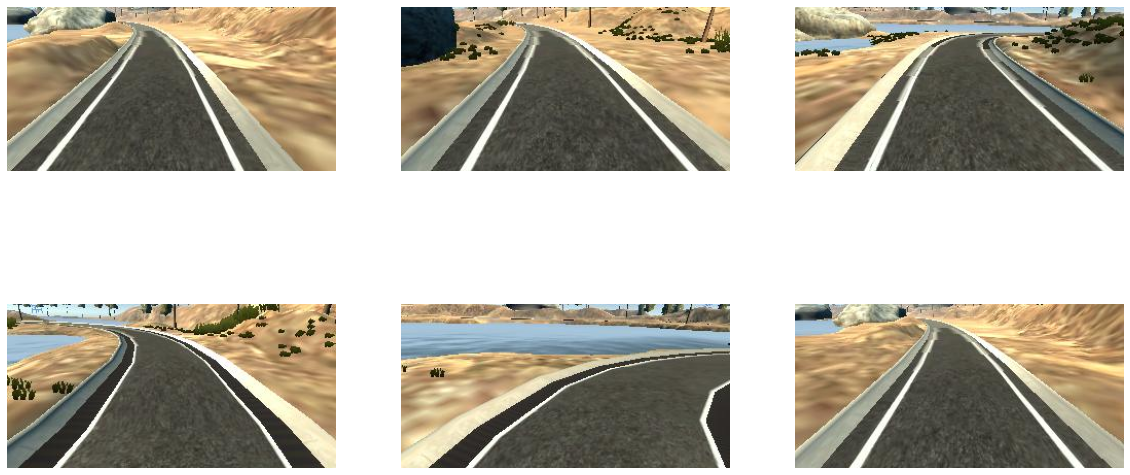

In [ ]:
## Đọc tất cả ảnh vào biến bgr_images và hiện lên
bgr_images = [cv2.imread(name) for name in image_names]
show_images(bgr_images)

## 3. Cài đặt thuật toán phát hiện vạch kẻ đường từ ảnh

Từ các phần trước, chúng ta đã được làm quen với các thuật toán xử lý ảnh cơ bản. Các thuật toán này hoàn toàn có thể được áp dụng để phát hiện làn đường trong ảnh hết sức dễ dàng. Ở phần này, chúng ta sẽ cùng xây dựng thuật toán phát hiện vạch kẻ đường từ đầu bằng các kĩ thuật xử lý ảnh như chuyển đổi hệ màu, lọc nhiễu, phát hiện cạnh. Thuật toán gồm 3 bước chính:


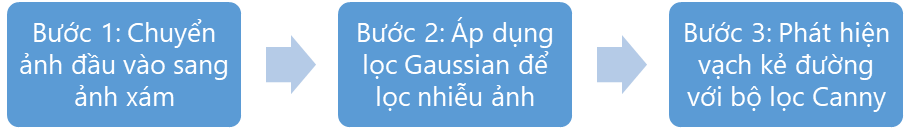



Trên thực tế, người ta thường triển khai các thuật toán thành các hàm trong Python để tiện sử dụng. Thuật toán phát hiện vạch kẻ đường được viết lại như sau:

In [ ]:
def find_lane_lines(img):
    """Phát hiện vạch kẻ đường
    Hàm này sẽ nhận vào một hình ảnh màu, ở hệ màu BGR,
    trả ra hình ảnh các vạch kẻ đường đã được lọc
    """

    # Chuyển ảnh đã đọc sang ảnh xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Áp dụng bộ lọc Gaussian để loại bỏ bớt nhiễu.
    # Các bạn có thể thử nghiệm các bộ lọc khác tại đây,
    # như bộ lọc Median hoặc Bilateral.
    img_gauss = cv2.GaussianBlur(gray, (11, 11), 0)

    # Áp dụng bộ lọc Canny với 2 ngưỡng.
    # Các bạn có thể điều chỉnh 2 ngưỡng này và xem sự thay đổi
    # trong ảnh kết quả
    thresh_low = 150
    thresh_high = 200
    img_canny = cv2.Canny(img_gauss, thresh_low, thresh_high)

    # Trả về kết quả vạch kẻ đường
    return img_canny


Thử nghiệm thuật toán với các ảnh vạch kẻ đường:

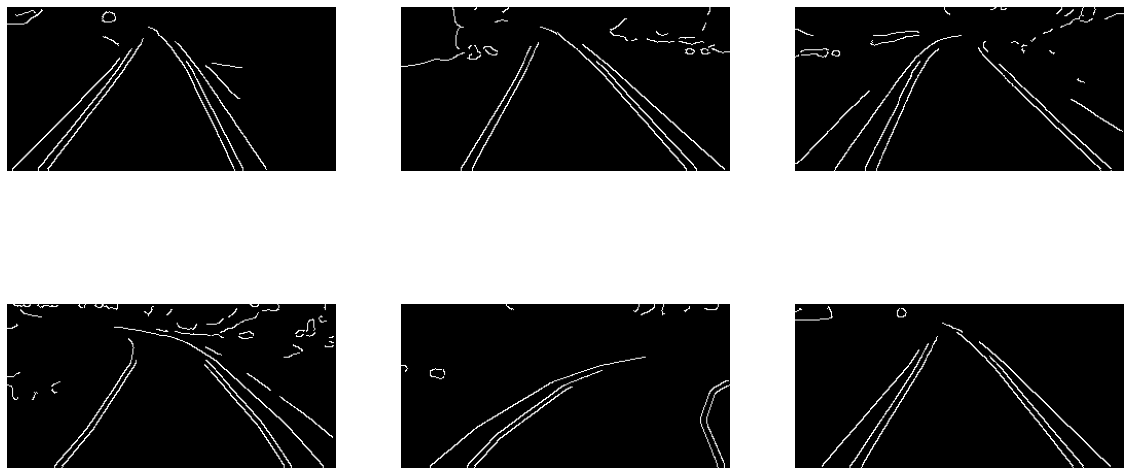

In [ ]:
list_img_lines = []
for img in bgr_images:
    img_lines = find_lane_lines(img)
    list_img_lines.append(img_lines)

# Hiện toàn bộ kết quả
show_images(list_img_lines)

## 4. Biến đổi birdview

Việc nhìn đường từ hướng xiên với mặt đường rất khó để tính toán góc quay phù hợp nhất cho xe. Ta sẽ thay đổi góc nhìn của ảnh từ hướng xiên tới hướng vuông góc với mặt đường bằng Birdview transform (góc nhìn từ trên xuống).

- Đọc thêm về biến đổi góc nhìn với 4 điểm: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/.

- Các phép biến đổi hình học: https://phamdinhkhanh.github.io/2020/01/06/ImagePreprocessing.html#21-c%C3%A1c-bi%E1%BA%BFn-%C4%91%E1%BB%95i-h%C3%ACnh-h%E1%BB%8Dc

Chúng ta lại cài đặt bước biến đổi birdview thành một hàm khác:

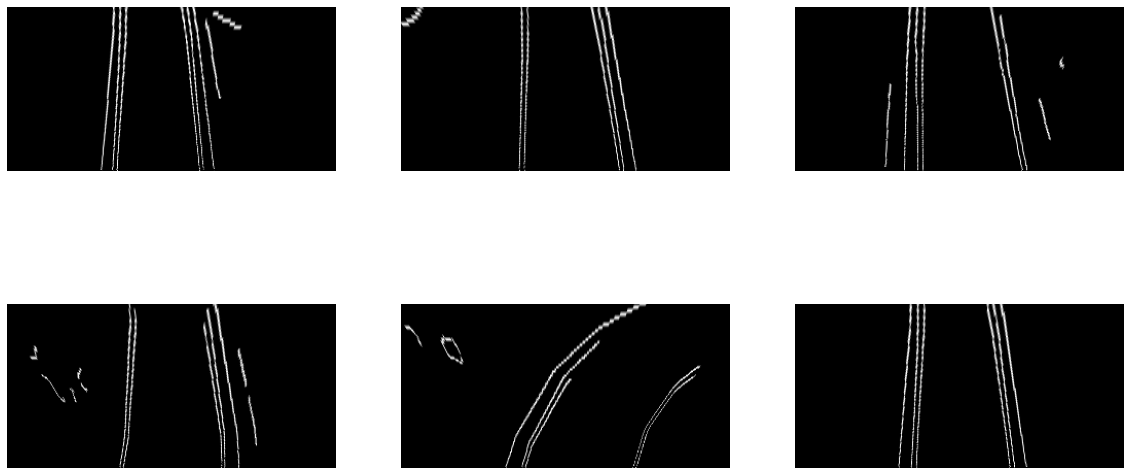

In [ ]:
def birdview_transform(img):
    IMAGE_H = 160
    IMAGE_W = 320
    src = np.float32([[0, IMAGE_H], [320, IMAGE_H], [0, IMAGE_H//3], [IMAGE_W, IMAGE_H//3]])
    dst = np.float32([[90, IMAGE_H], [230, IMAGE_H], [-10, 0], [IMAGE_W+10, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    return warped_img

# Áp dụng các biến đổi birdview với hình ảnh kết quả của bộ lọc Canny
birdview_images = [birdview_transform(img) for img in list_img_lines]
show_images(birdview_images, cmap="gray")

## 5. Tìm hai điểm trái / phải

Sau khi có được ảnh birdview, một phương pháp đơn giản giúp xác định vị trí xe so với làn đường là tìm 2 điểm, một điểm thuộc vạch kẻ đường bên trái và một điểm thuộc vạch kẻ đường bên phải. Sau cùng, ta xét vị trí của điểm giữa xe so với hai điểm đó để xác định độ lệch của xe so với làn đường và tính toán góc lái phù hợp.

Đoạn code bên dưới sẽ thực hiện xét một vạch kẻ ngang bức ảnh, cách mép trên ảnh một khoảng bằng 70% chiều cao ảnh. Tiếp đó, chúng ta tính vị trí tâm ảnh. Từ vị trí tâm này, ta duyệt sang 2 bên, tìm điểm ảnh có giá trị khác 0 đầu tiên, và coi đó là vị trí vạch kẻ đường bên trái và bên phải. Ta định nghĩa trước độ rộng đường lane_width = 100. Như vậy có thể dùng độ rộng này để tìm một trong hai điểm trái / phải khi chỉ nhìn thấy điểm còn lại.



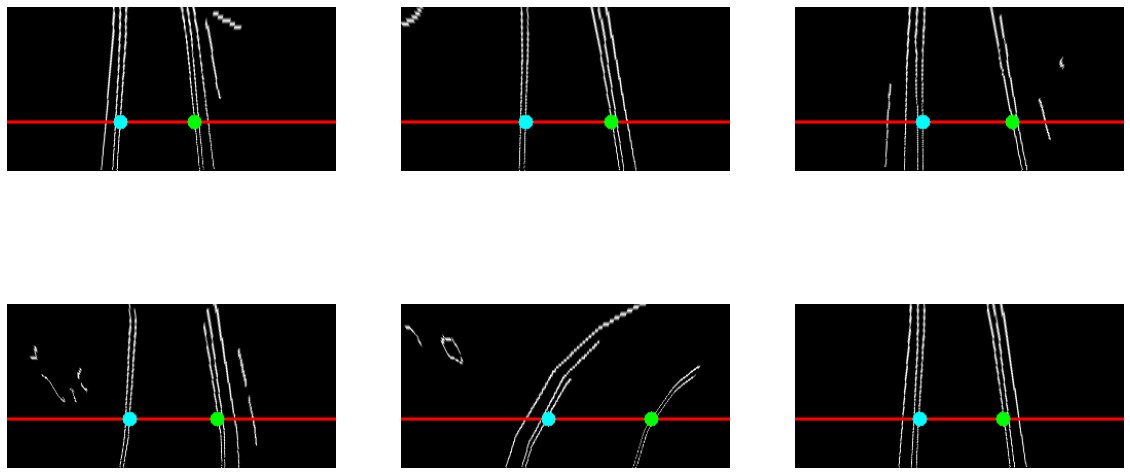

In [ ]:
def find_left_right_points(image, draw=False):

    im_height, im_width = image.shape[:2]
    if draw: viz_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Vạch kẻ sử dụng để xác định tâm đường
    interested_line_y = int(im_height * 0.7)
    if draw: cv2.line(viz_img, (0, interested_line_y), (im_width, interested_line_y), (0, 0, 255), 2) 
    interested_line = image[interested_line_y, :]

    # Xác định điểm bên trái và bên phải
    left_point = -1
    right_point = -1
    lane_width = 100
    center = im_width // 2

    # Tìm điểm bên trái và bên phải bằng cách duyệt từ tâm ra
    for x in range(center, 0, -1):
        if interested_line[x] > 0:
            left_point = x
            break
    for x in range(center + 1, im_width):
        if interested_line[x] > 0:
            right_point = x
            break

    # Dự đoán điểm bên phải khi chỉ nhìn thấy điểm bên trái
    if left_point != -1 and right_point == -1:
        right_point = left_point + lane_width

    # Dự đoán điểm bên trái khi chỉ thấy điểm bên phải
    if right_point != -1 and left_point == -1:
        left_point = right_point - lane_width

    # Vẽ hai điểm trái / phải lên ảnh
    if draw: 
        if left_point != -1:
            viz_img = cv2.circle(viz_img, (left_point, interested_line_y), 7, (255,255,0), -1)
        if right_point != -1:
            viz_img = cv2.circle(viz_img, (right_point, interested_line_y), 7, (0,255,0), -1)

    return left_point, right_point, viz_img

viz_images = []
for img in birdview_images:
    left_point, right_point, viz_img = find_left_right_points(img, draw=True)
    viz_images.append(viz_img)

show_images(viz_images)

### 6. Tính toán góc lái và tốc độ

Chúng ta sẽ viết thêm hàm `calculate_control_signal()` để tính toán tốc độ và góc lái cho xe dựa trên ảnh đầu vào. Sau bước `find_land_lines()` sử dụng Canny để tìm kiếm các vạch kẻ đường, hình ảnh sẽ được đưa qua `birdview_transform()` để thực hiện chuyển đổi birdview, lấy góc nhìn từ trên xuống. Tiếp đó là thuật toán tìm kiếm các điểm trái / phải của làn đường thông qua hàm `find_left_right_points()`. Từ hai điểm trái và phải,  chúng ta hoàn toàn có thể tính toán được độ lệch của xe so với mặt đường (coi camera ở chính giữa xe, thì tâm ảnh `im_center` cũng là tâm của xe):

In [ ]:
def calculate_control_signal(img):
    """Tính toán để tìm tốc độ và góc lái cho xe từ ảnh đầu vào
    """

    # Xử lý ảnh để tìm các điểm trái / phải
    img_lines = find_lane_lines(img)
    img_birdview = birdview_transform(img_lines)
    left_point, right_point, viz_img = find_left_right_points(img_birdview, draw=True)

    # Hiển thị kết quả xử lý ảnh
    cv2.imshow("Result", viz_img)
    cv2.waitKey(1)

    # Tính toán tốc độ và góc lái
    throttle = 0.5 # Tốc độ đang được đặt là 50% tốc độ cao nhất
    steering_angle = 0
    im_center = img.shape[1] // 2
    # Nếu tìm thấy điểm trái và điểm phải,
    # các điểm này sẽ có giá trị khác -1
    if left_point != -1 and right_point != -1:

        # Tính toán độ lệch giữa điểm giữa xe và làn đường
        center_point = (right_point + left_point) // 2
        center_diff =  im_center - center_point

        # Tính toán góc lái tỷ lệ với độ lệch
        steering_angle = - float(center_diff * 0.01)

    return throttle, steering_angle
